# Sentiment Analysis Experiments

Analyzing whether conversations generated with agents assigned evil attributes have a more negative polarity compared to agents with friendly attributes

In [2]:
import os
import pandas as pd
from SentimentAnalysis import *

# Initialize a dictionary to store DataFrames
dataframes = {}

# Get the current working directory
directory_path = os.getcwd()

# Iterate over all files in the current directory
for filename in os.listdir(directory_path):
    if filename.endswith(".csv"):  # Only process CSV files
        file_path = os.path.join(directory_path, filename)
        # Use the filename without the extension as the key
        file_key = os.path.splitext(filename)[0]
        # Load the CSV file into a DataFrame and store it in the dictionary
        dataframes[file_key] = pd.read_csv(file_path)
        print(f"Loaded {file_key}")

Loaded 2sentimentAnalysisEvil_1_characterPrompt_without_history
Loaded 2sentimentAnalysisEvil_1_without_history
Loaded 2sentimentAnalysisEvil_1_with_history
Loaded 2sentimentAnalysisEvil_2_characterPrompt_without_history
Loaded 2sentimentAnalysisEvil_2_without_history
Loaded 2sentimentAnalysisEvil_2_with_history
Loaded 2sentimentAnalysisWithHistEvil_1_characterRelationshipPrompt_without_history
Loaded 2sentimentAnalysisWithHistEvil_1_without_history
Loaded 2sentimentAnalysisWithHistEvil_2_characterRelationshipPrompt_without_history
Loaded 2sentimentAnalysisWithHistEvil_2_without_history
Loaded 2sentimentAnalysis_1_without_history
Loaded 2sentimentAnalysis_2_without_history
Loaded 3sentimentAnalysisWithHistEvil_1_characterRelationshipPrompt_without_history
Loaded 3sentimentAnalysisWithHistEvil_1_without_history
Loaded 3sentimentAnalysisWithHistEvil_2_characterRelationshipPrompt_without_history
Loaded 3sentimentAnalysisWithHistEvil_2_without_history
Loaded sentimentAnalysisEvil_1_charact

Preparing dataframe containing all utterances and sentiment scores obtained using Spacy

In [3]:
utterances_data = []

for source, df in dataframes.items():
    df.reset_index(inplace=True)  # Ensure each conversation has a unique ID based on its index
    # Apply sentiment analysis to the "Details" column
    df['SentimentAnalysis'] = df['Details'].apply(analyze_sentiments)
    
    # Process each row in the DataFrame
    for index, row in df.iterrows():
        if 'SentimentAnalysis' in row and isinstance(row['SentimentAnalysis'], list):
            utterance_order = 1  # Initialize order for each new conversation
            for sentiment_analysis in row['SentimentAnalysis']:
                utterance, sentiment = sentiment_analysis
                polarity = sentiment["polarity"]
                subjectivity = sentiment["subjectivity"]
                
                # Extract speaker's name and utterance text
                speaker_name = sentiment['speaker']
                utterance_text = utterance
                
                # Append the data including the order of the utterance within the conversation
                utterances_data.append({
                    "Subject": speaker_name, 
                    "Source": source,  # Adding the source here
                    "Utterance": utterance_text,
                    "Polarity" : polarity,
                    "Subjectivity"  :subjectivity,
                    "Conversation_ID": F"{index}_{source}",  
                    "UtteranceOrder": utterance_order,
                })
                utterance_order += 1  # Increment order for the next utterance in the same conversation

# Convert the list to a DataFrame
utterances_df = pd.DataFrame(utterances_data)


Calculate average polarity per conversation to decorrelate data points

In [4]:
for df_name, df in dataframes.items():
    df['AveragePolarity'] = df['SentimentAnalysis'].apply(average_polarity)
    df['Source'] = df_name


all_data = [df[['Source', 'AveragePolarity']] for df_name, df in dataframes.items()]
combined_df = pd.concat(all_data, ignore_index=True)
combined_df = combined_df.dropna(subset=['AveragePolarity'])

## Comparing Normal Simulation to Evil with no History

comparing whether agents with evil attributes have more negative conversations compared to agents with good attributes

In [5]:
reference_groups = [
    'sentimentAnalysis_1_without_history',
    'sentimentAnalysis_2_without_history',
    '2sentimentAnalysis_1_without_history',
    '2sentimentAnalysis_2_without_history'
]

source_groups = [
    'sentimentAnalysisEvil_1_without_history',
    'sentimentAnalysisEvil_2_without_history',
    '2sentimentAnalysisEvil_1_without_history',
    '2sentimentAnalysisEvil_2_without_history'
]


result_anova = anova_sentiment(reference_groups+source_groups, combined_df)
print(result_anova)


           sum_sq     df         F    PR(>F)
Source    0.28036    7.0  3.866723  0.000438
Residual  4.06032  392.0       NaN       NaN


In [6]:
# Perform comparisons
results_df = compare_groups(combined_df, reference_groups, source_groups)

# Display results
display(results_df)

,Reference Group,Source Group,T-Statistic,P-Value
0,sentimentAnalysis_1_without_history,sentimentAnalysisEvil_1_without_history,-1.382013,0.170113
1,sentimentAnalysis_1_without_history,sentimentAnalysisEvil_2_without_history,-0.365930,0.715215
2,sentimentAnalysis_1_without_history,2sentimentAnalysisEvil_1_without_history,-0.547191,0.585494
3,sentimentAnalysis_1_without_history,2sentimentAnalysisEvil_2_without_history,0.579393,0.563654
4,sentimentAnalysis_2_without_history,sentimentAnalysisEvil_1_without_history,-4.316823,0.000039
5,sentimentAnalysis_2_without_history,sentimentAnalysisEvil_2_without_history,-3.328370,0.001234
6,sentimentAnalysis_2_without_history,2sentimentAnalysisEvil_1_without_history,-3.423943,0.000909
7,sentimentAnalysis_2_without_history,2sentimentAnalysisEvil_2_without_history,-2.140049,0.034912
8,2sentimentAnalysis_1_without_history,sentimentAnalysisEvil_1_without_history,-0.503465,0.615804
9,2sentimentAnalysis_1_without_history,sentimentAnalysisEvil_2_without_history,0.662048,0.509511


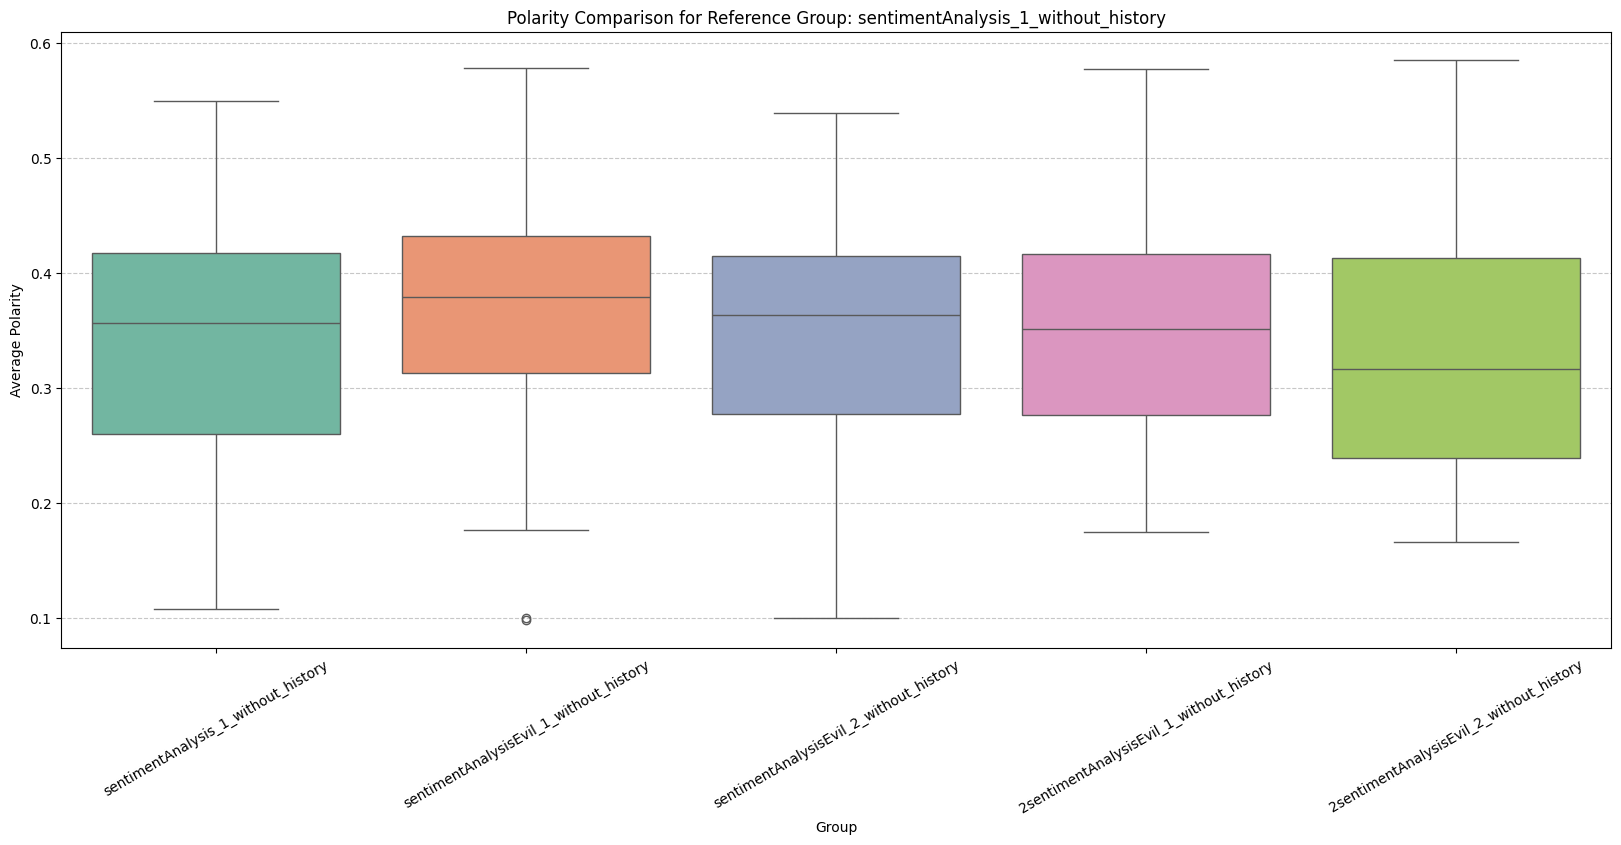

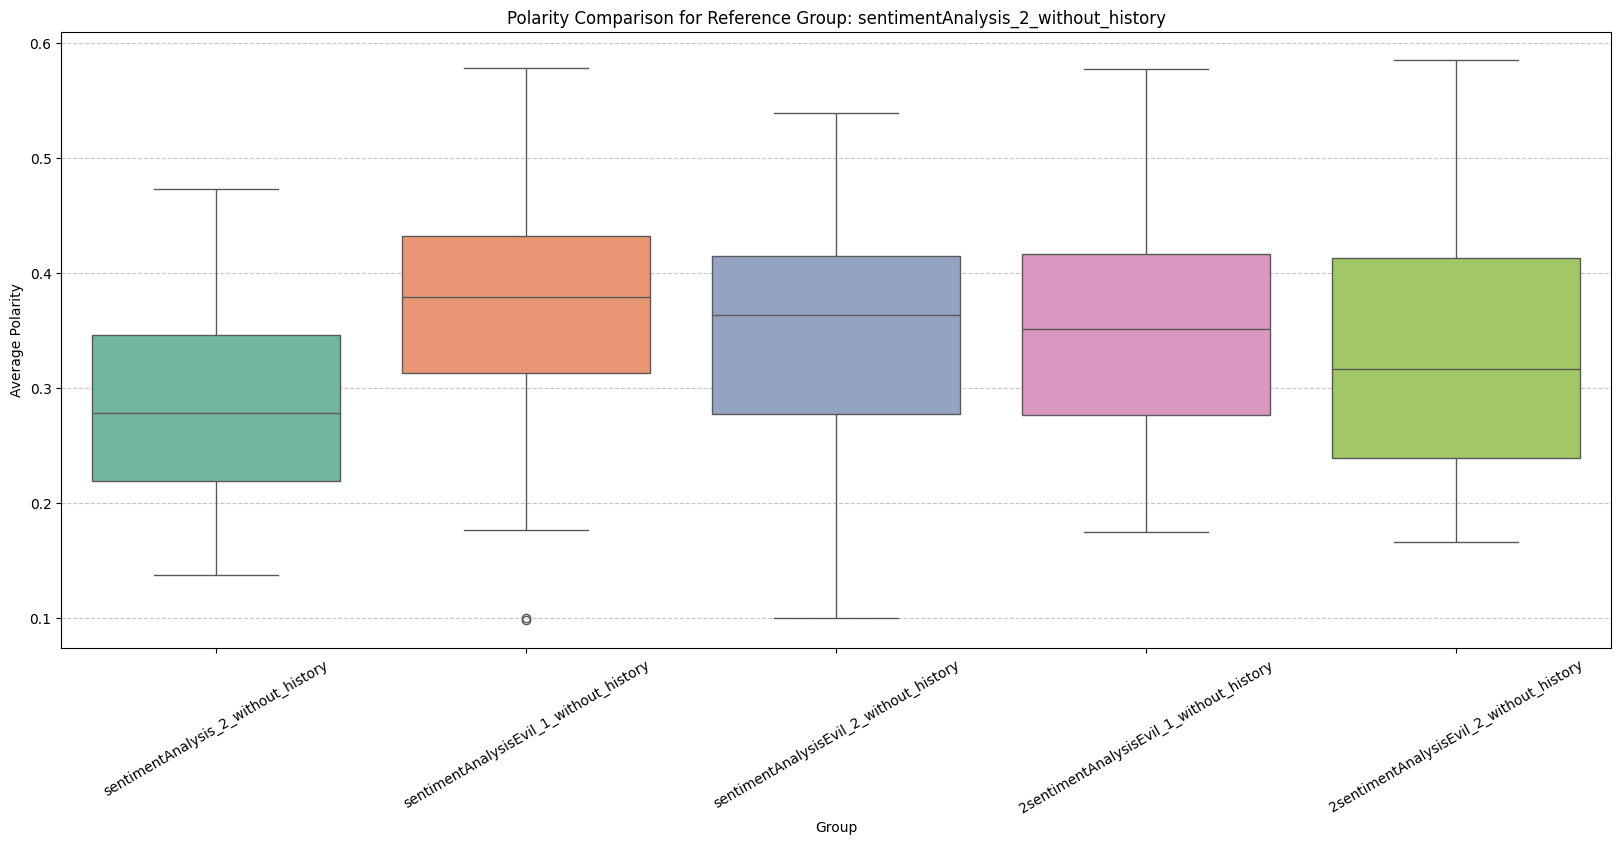

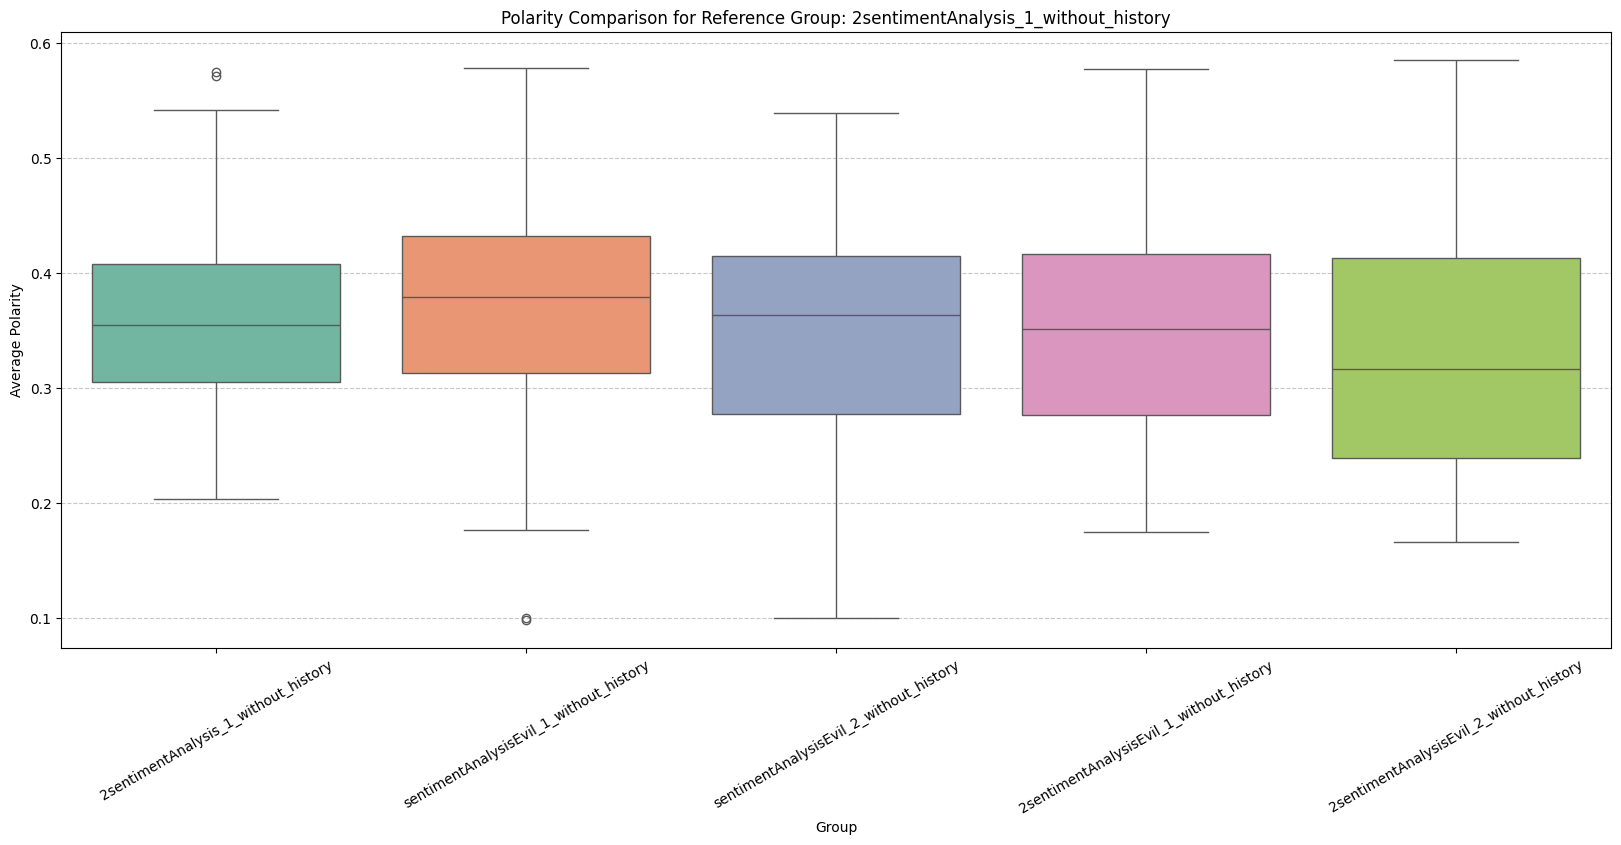

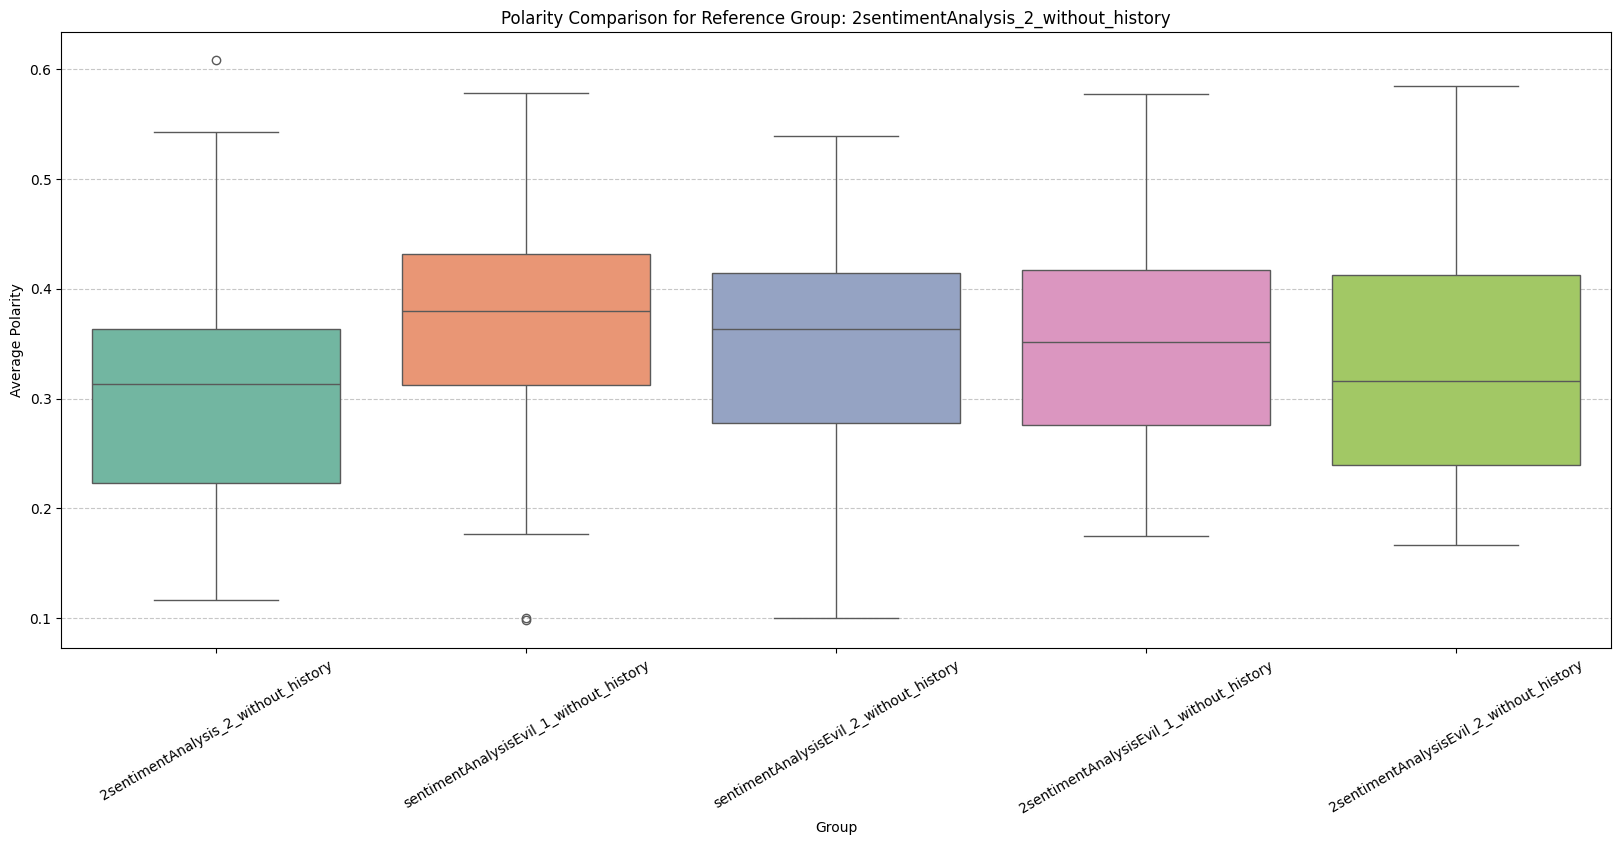

In [7]:
plot_boxplots_per_reference_group(
    combined_df,
    reference_groups,
    source_groups
)

## Comparing normal & evil with character prompt no history

Since agents with evil attributes do not have significantly more negative conversations as seen above conversations were generated using a changed prompt. 
Given the "lost in the middle" bias agents display the negative attributes were now placed in the very end of the prompt.

In [8]:
reference_groups = [
    'sentimentAnalysis_1_without_history',
    'sentimentAnalysis_2_without_history',
    '2sentimentAnalysis_1_without_history',
    '2sentimentAnalysis_2_without_history'
]

source_groups = [
        'sentimentAnalysisEvil_1_characterPrompt_without_history',
    'sentimentAnalysisEvil_2_characterPrompt_without_history',
    '2sentimentAnalysisEvil_1_characterPrompt_without_history',
    '2sentimentAnalysisEvil_2_characterPrompt_without_history'

]


result_anova = anova_sentiment(reference_groups+source_groups, combined_df)
print(result_anova)


            sum_sq     df          F        PR(>F)
Source    7.445275    7.0  67.116682  3.216149e-63
Residual  6.212098  392.0        NaN           NaN


In [9]:
# Perform comparisons
results_df = compare_groups(combined_df, reference_groups, source_groups)

# Display results
display(results_df)

,Reference Group,Source Group,T-Statistic,P-Value
0,sentimentAnalysis_1_without_history,sentimentAnalysisEvil_1_characterPrompt_withou...,11.916223,2.004718e-20
1,sentimentAnalysis_1_without_history,sentimentAnalysisEvil_2_characterPrompt_withou...,9.642552,1.317978e-15
2,sentimentAnalysis_1_without_history,2sentimentAnalysisEvil_1_characterPrompt_witho...,12.316716,4.126360e-21
3,sentimentAnalysis_1_without_history,2sentimentAnalysisEvil_2_characterPrompt_witho...,9.693594,1.839031e-15
4,sentimentAnalysis_2_without_history,sentimentAnalysisEvil_1_characterPrompt_withou...,10.384161,9.851130e-17
5,sentimentAnalysis_2_without_history,sentimentAnalysisEvil_2_characterPrompt_withou...,7.976855,7.462396e-12
6,sentimentAnalysis_2_without_history,2sentimentAnalysisEvil_1_characterPrompt_witho...,10.834323,1.727108e-17
7,sentimentAnalysis_2_without_history,2sentimentAnalysisEvil_2_characterPrompt_witho...,8.124873,5.909206e-12
8,2sentimentAnalysis_1_without_history,sentimentAnalysisEvil_1_characterPrompt_withou...,13.670511,5.714929e-23
9,2sentimentAnalysis_1_without_history,sentimentAnalysisEvil_2_characterPrompt_withou...,11.177150,3.951440e-18


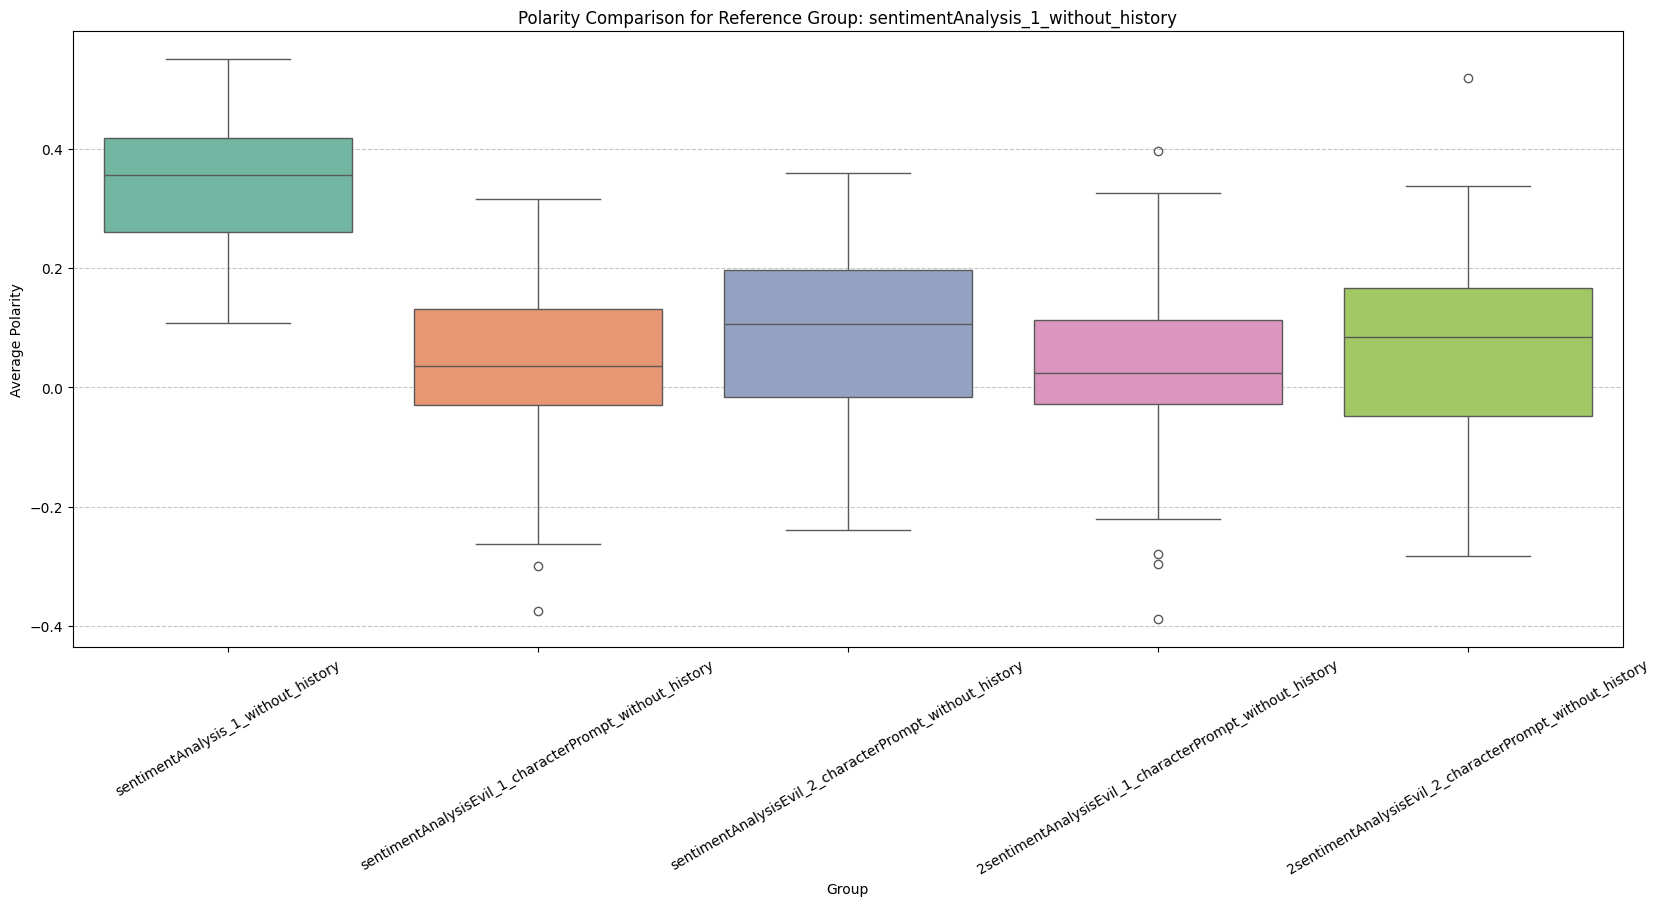

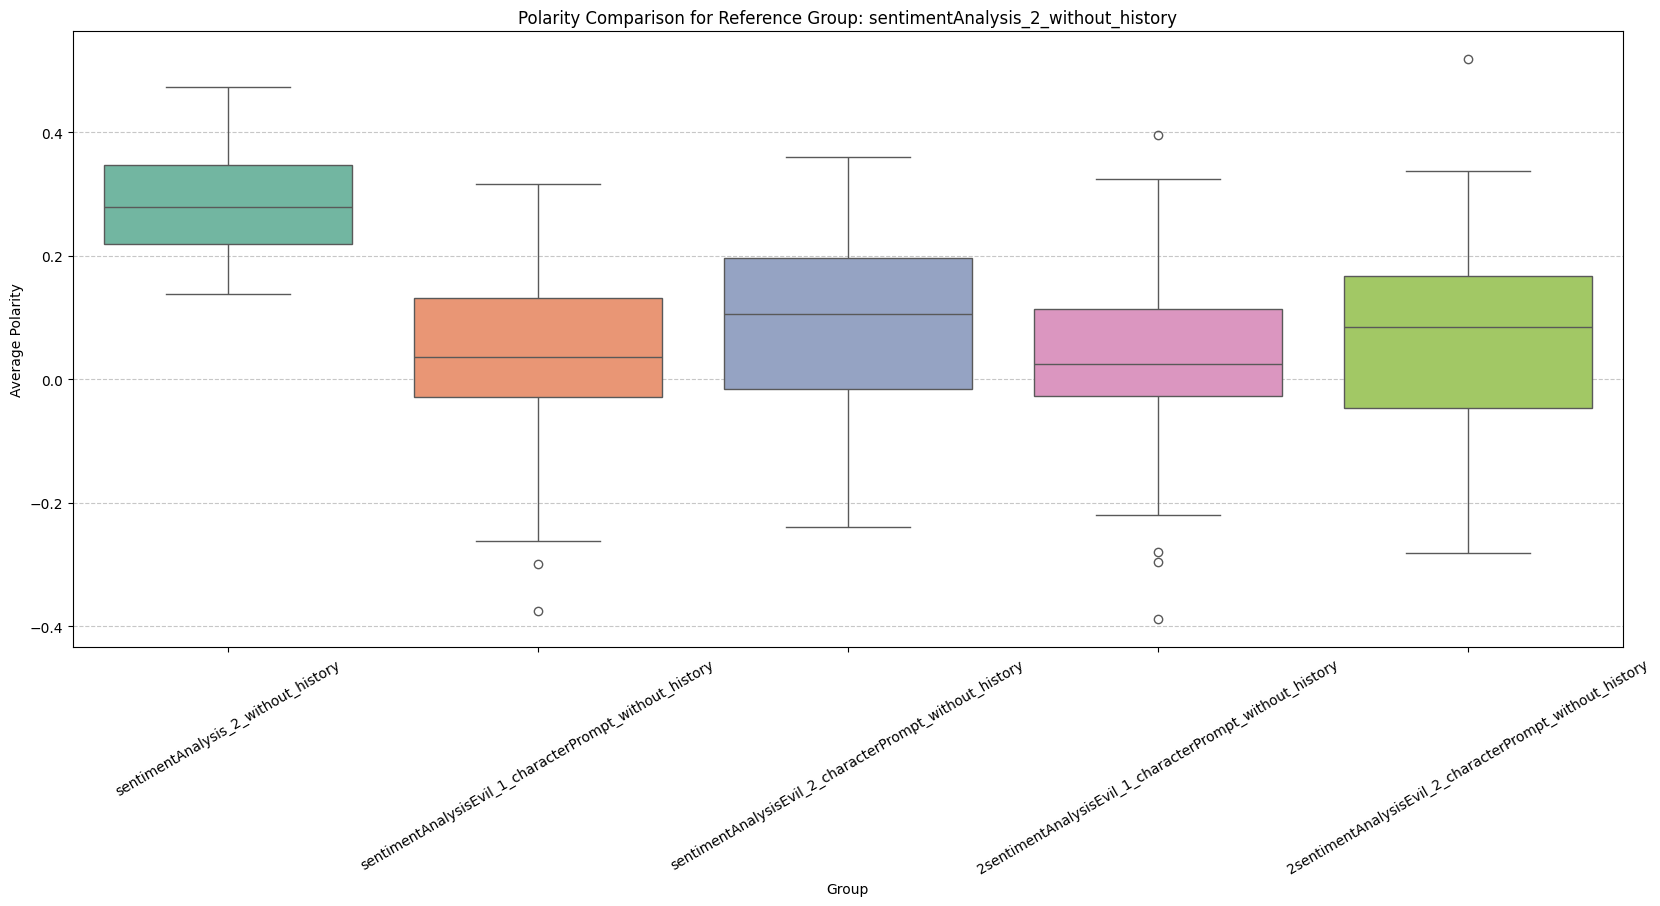

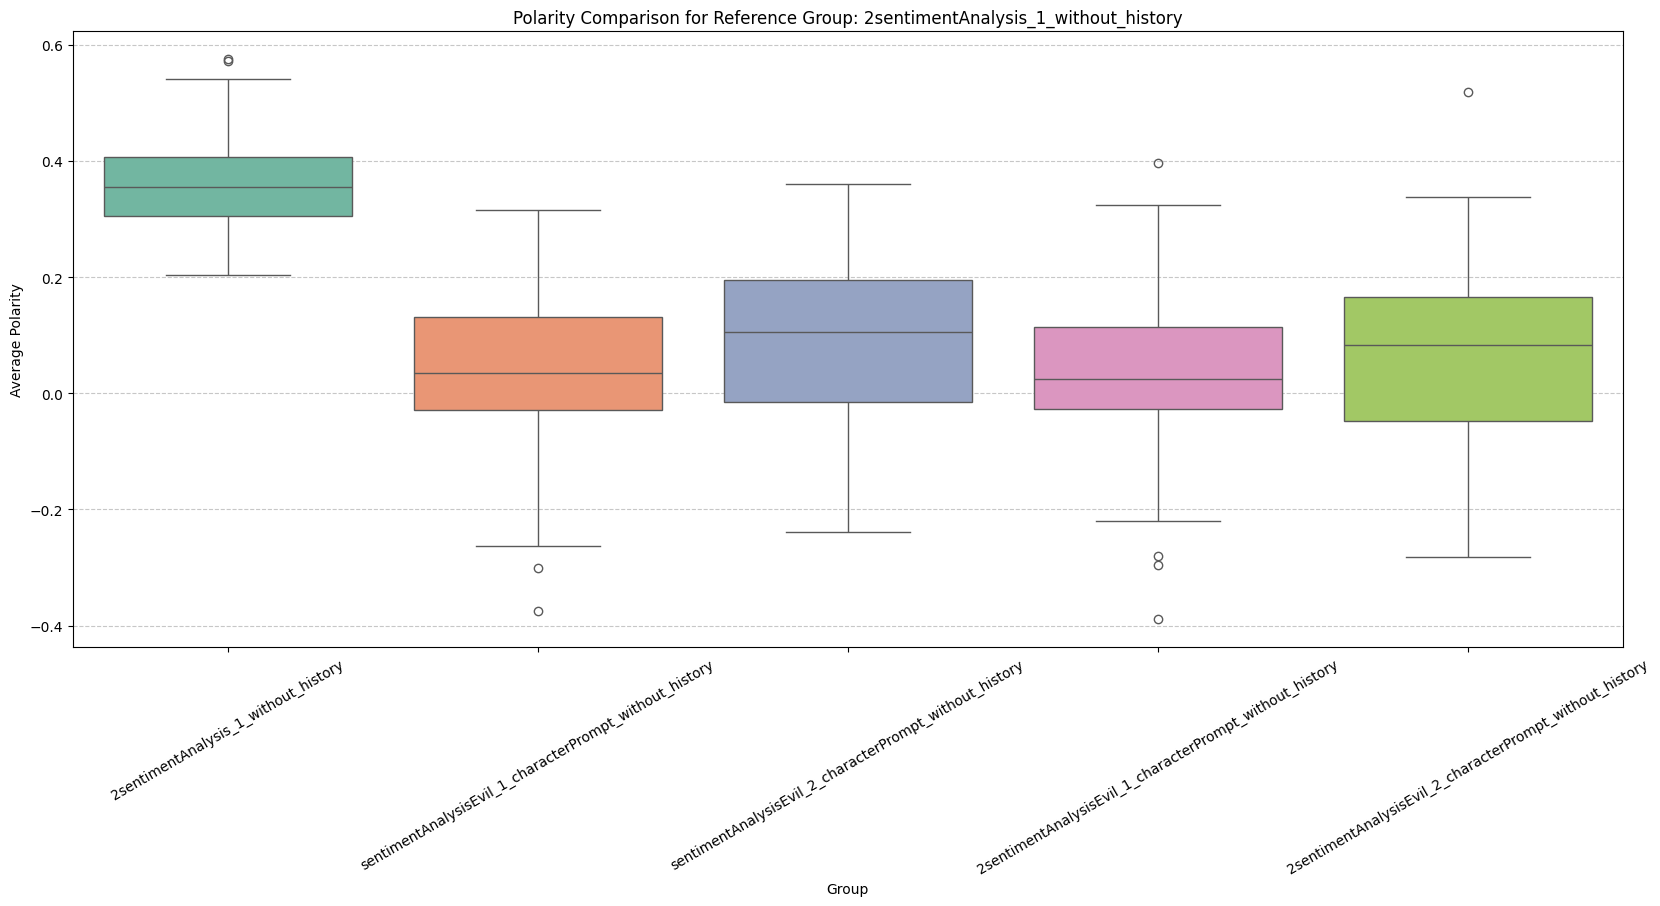

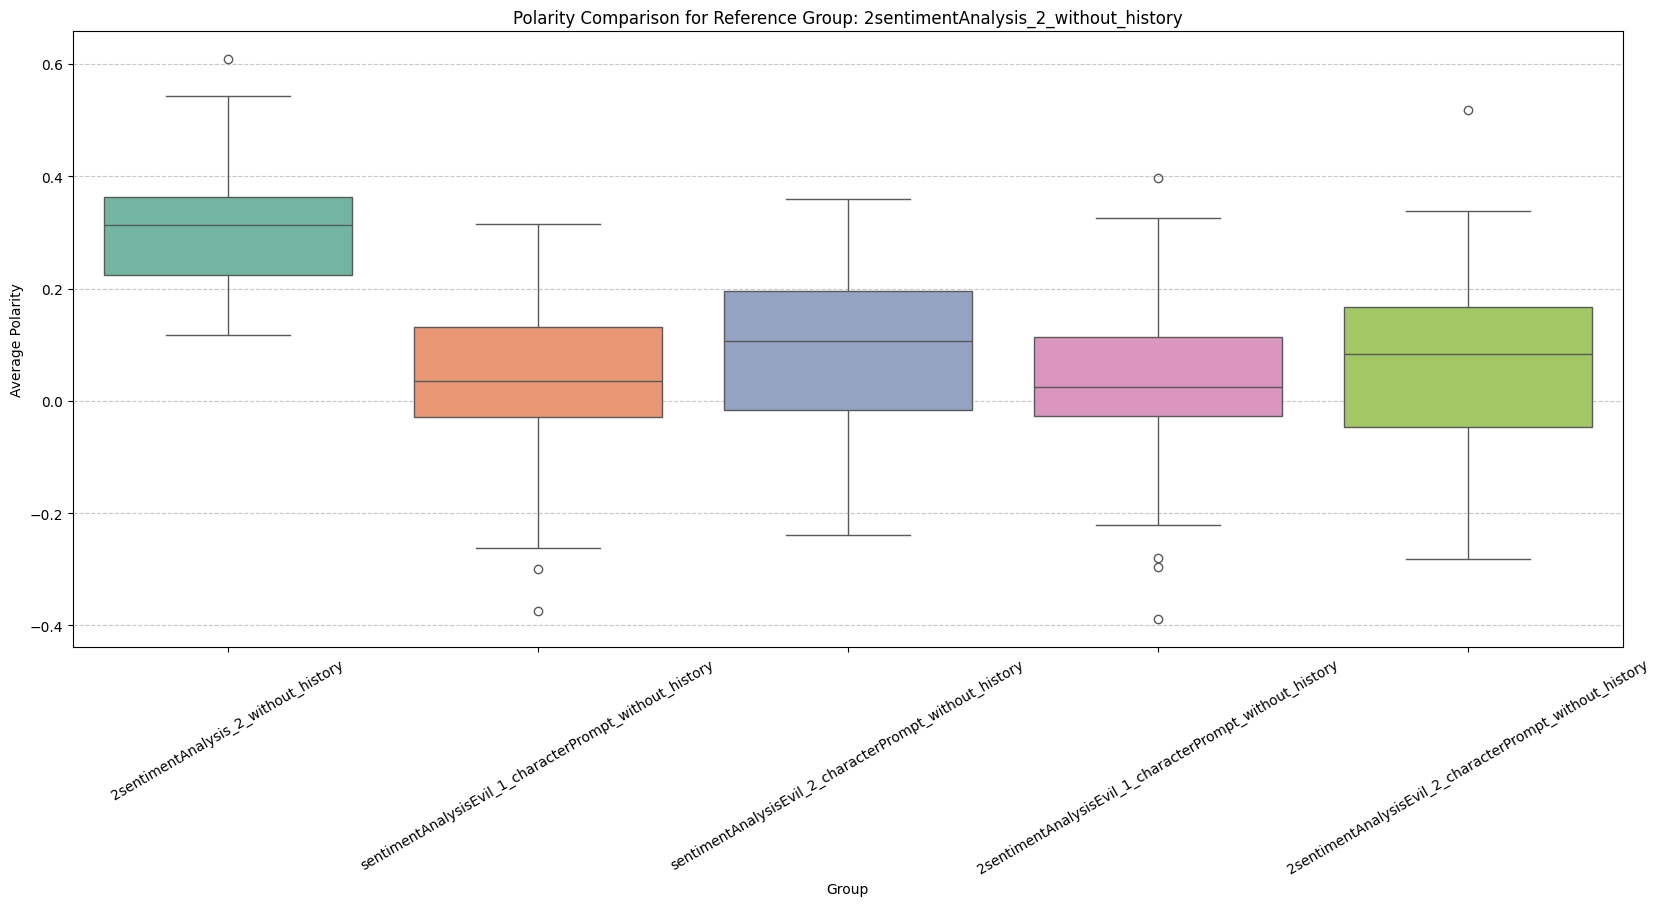

In [10]:

plot_boxplots_per_reference_group(
    combined_df,
    reference_groups,
    source_groups
)


## Checking in how many of the conversations the problem is mentioned

When agents get bad experiences with another agent implented into their memory stream do they adress these experiences in their conversations with the other agent?

In [11]:
import re

# Words to search for in the utterances
keywords = re.compile(r'\b(steal|stolen|stole|stealing|theft|rob|robbery|dollar|money)\b', re.IGNORECASE)


source_order = [
    'sentimentAnalysisEvil_1_with_history',
    'sentimentAnalysisEvil_2_with_history',
    '2sentimentAnalysisEvil_1_with_history',
    '2sentimentAnalysisEvil_2_with_history',
    
    'sentimentAnalysisWithHistEvil_1_without_history',
    'sentimentAnalysisWithHistEvil_2_without_history',
    '2sentimentAnalysisWithHistEvil_1_without_history',
    '2sentimentAnalysisWithHistEvil_2_without_history',
    '3sentimentAnalysisWithHistEvil_1_without_history',
    '3sentimentAnalysisWithHistEvil_2_without_history',

    'sentimentAnalysisWithHistEvil_1_characterRelationshipPrompt_without_history',
    'sentimentAnalysisWithHistEvil_2_characterRelationshipPrompt_without_history',
    '2sentimentAnalysisWithHistEvil_1_characterRelationshipPrompt_without_history',
    '2sentimentAnalysisWithHistEvil_2_characterRelationshipPrompt_without_history',
    '3sentimentAnalysisWithHistEvil_1_characterRelationshipPrompt_without_history',
    '3sentimentAnalysisWithHistEvil_2_characterRelationshipPrompt_without_history'
]


# Initialize data structure to hold the counts
unique_conversation_counts = []

# Assuming 'utterances_df' contains the processed utterance data
for source, group in utterances_df.groupby('Source'):
    # Filter for the subset of sources you want to analyze
    if source in source_order:

        for conversation_id, conversation_group in group.groupby('Conversation_ID'):
            # Check if any utterance in the conversation mentions a keyword
            keyword_found = False
            for _, row in conversation_group.iterrows():
                if keywords.search(row['Utterance']):
                    keyword_found = True
                    break  # Count only one mention per conversation
            
            # Add the result if a keyword was found in the conversation
            unique_conversation_counts.append({
                "Source": source,
                "Conversation_ID": conversation_id,
                "KeywordMentioned": int(keyword_found)  # 1 if found, 0 otherwise
            })

# Convert the counts to a DataFrame
unique_conversation_counts_df = pd.DataFrame(unique_conversation_counts)


# Optionally, aggregate the counts by source for summary
summary = unique_conversation_counts_df.groupby('Source')['KeywordMentioned'].sum().reset_index()
summary.columns = ['Source', 'TotalKeywordMentions']
# Sort the summary DataFrame based on the custom source order
summary['Source'] = pd.Categorical(summary['Source'], categories=source_order, ordered=True)
sorted_summary = summary.sort_values('Source').reset_index(drop=True)

# Display the sorted summary
display(sorted_summary)



,Source,TotalKeywordMentions
0,sentimentAnalysisEvil_1_with_history,42
1,sentimentAnalysisEvil_2_with_history,30
2,2sentimentAnalysisEvil_1_with_history,39
3,2sentimentAnalysisEvil_2_with_history,39
4,sentimentAnalysisWithHistEvil_1_without_history,11
5,sentimentAnalysisWithHistEvil_2_without_history,16
6,2sentimentAnalysisWithHistEvil_1_without_history,33
7,2sentimentAnalysisWithHistEvil_2_without_history,27
8,3sentimentAnalysisWithHistEvil_1_without_history,28
9,3sentimentAnalysisWithHistEvil_2_without_history,19


- 0 - 3 in the summary table are conversations generated right after the bad experience was inserted into the memory stream. They show a high number of conversations adressing the problem (>=30)
- 4 - 9 are conversations where the memory was inserted in the beginning of the simulation. They show a decline in number of conversations between 1 (run for 100 steps) and 2 (run for 700 steps). Overall the number of conversation adressing the problem varies greatly (from 11 to 33).
- 10 - 15 are generated with a changed prompt which includes a summary of the agents' relationship. Here the bad experiences was also inserted at the beginnning of the simulation. It shows a consistently high number adressing the problem (>40) independently from whether it is 1 or 2.
